#  E-commerce Business Transaction Analysis

This notebook provides a comprehensive analysis of e-commerce transaction data including:
- Data cleaning and preprocessing
- Exploratory data analysis (EDA)
- Product category analysis
- Customer segmentation using RFM analysis
- Cohort analysis for customer retention insights

---


##  1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from fim import arules
import warnings
from operator import attrgetter
import re
# Configuration
warnings.filterwarnings("ignore")
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)


##  2. Initial Data Exploration


In [2]:
# Load the data
df = pd.read_csv('sales_transaction.csv')
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [3]:
# Initial data exploration

print(f"Dataset shape: {df.shape}")
print("\nColumn information:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print(f"\nDuplicate rows: {df.duplicated().sum()}")


Dataset shape: (536350, 8)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB
None

Missing values:
TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

Duplicate rows: 5200


In [4]:
# The dataset contains cancelled transactions
df[df['TransactionNo'].str.match(r'[A-z-Za].')]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
1616,C581484,12/9/2019,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom
1617,C581490,12/9/2019,22178,Victorian Glass Hanging T-Light,6.19,-12,14397.0,United Kingdom
1618,C581490,12/9/2019,23144,Zinc T-Light Holder Stars Small,6.04,-11,14397.0,United Kingdom
1619,C581568,12/9/2019,21258,Victorian Sewing Box Large,6.19,-5,15311.0,United Kingdom
1620,C581569,12/9/2019,84978,Hanging Heart Jar T-Light Holder,6.19,-1,17315.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


##  3. Data Cleaning & Preprocessing

### Cleaning and handling cancelled orders

In [ ]:
sales_clean = df.copy()
initial_rows = len(sales_clean)

print(f"Initial rows: {initial_rows:,}")

# drop rows with missing CustomerNo values
sales_clean.dropna(subset = 'CustomerNo', inplace = True)

# Remove duplicates
sales_clean.drop_duplicates(inplace=True)

# Convert date column
sales_clean['Date'] = pd.to_datetime(sales_clean['Date'])

# convert CustomerNo to string and strip off decimals
sales_clean['CustomerNo'] = sales_clean['CustomerNo'].astype(str).replace(r'\..+', '',regex=True)

# Country names
sales_clean['Country'] = sales_clean['Country'].str.replace('EIRE', 'Ireland')

# drop last month (the dataset does not contain the whole December)
sales_clean = sales_clean[sales_clean['Date']<=pd.to_datetime('2019-11-30')]

# Find valid Customer-Product pairs from those in-period positives
valid_pairs = sales_clean[sales_clean['Quantity'] > 0][['CustomerNo', 'ProductNo']].drop_duplicates()

# Keep only valid pairs
df_filtered = sales_clean.merge(valid_pairs, on=['CustomerNo', 'ProductNo'], how='inner')

# Calculate net quantities by customer and product
net_quantities = df_filtered.groupby(['CustomerNo', 'ProductNo'])['Quantity'].sum().reset_index()

# Exclude fully cancelled transactions
remaining = net_quantities[net_quantities['Quantity'] > 0]

# Merge to bring back only actual sales (net > 0)
merged = df_filtered.merge(remaining, on=['CustomerNo', 'ProductNo'], suffixes=('', '_net'))

# Keep only positive quantities that are part of net-positive Customer-Product combos
sales_clean = merged[merged['Quantity'] > 0].drop(columns='Quantity_net')

print(f"Final dataset: {len(sales_clean):,} rows ({len(sales_clean)/initial_rows*100:.1f}% of original data retained)")

sales_clean.head()

Initial rows: 536,350
Final dataset: 496,230 rows (92.5% of original data retained)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432,United Kingdom
1,576078,2019-11-13,84879,Assorted Colour Bird Ornament,11.98,12,14432,United Kingdom
2,572309,2019-10-23,84879,Assorted Colour Bird Ornament,11.98,7,14432,United Kingdom
3,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432,United Kingdom
4,576078,2019-11-13,82486,3 Drawer Antique White Wood Cabinet,19.42,2,14432,United Kingdom


### Feature engineering

In [6]:
# Calculate revenue
sales_clean['revenue'] = sales_clean['Price'] * sales_clean['Quantity']

# Extract date components
sales_clean['year'] = sales_clean['Date'].dt.year
sales_clean['month'] = sales_clean['Date'].dt.month
sales_clean['day_of_week'] = sales_clean['Date'].dt.day_name()
sales_clean['dow'] = sales_clean['Date'].dt.day_of_week

top_products_revenue = sales_clean.groupby('ProductName')['revenue'].sum().nlargest(10).sort_values(ascending=True)

# Top countries by revenue
top_countries = sales_clean.groupby('Country')['revenue'].sum().nlargest(5)

# Monthly revenue trend
monthly_revenue = sales_clean.groupby(['year', 'month'])['revenue'].sum().reset_index()
monthly_revenue['date'] = pd.to_datetime(monthly_revenue[['year', 'month']].assign(day=1))

sales_clean.head()


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,revenue,year,month,day_of_week,dow
0,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432,United Kingdom,48.32,2019,11,Saturday,5
1,576078,2019-11-13,84879,Assorted Colour Bird Ornament,11.98,12,14432,United Kingdom,143.76,2019,11,Wednesday,2
2,572309,2019-10-23,84879,Assorted Colour Bird Ornament,11.98,7,14432,United Kingdom,83.86,2019,10,Wednesday,2
3,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432,United Kingdom,24.16,2019,11,Saturday,5
4,576078,2019-11-13,82486,3 Drawer Antique White Wood Cabinet,19.42,2,14432,United Kingdom,38.84,2019,11,Wednesday,2


### Create Categories

In [27]:
# Create product categories based on product names using regex

def categorize_product(product_name):
    if pd.isna(product_name):
        return 'Unknown'
    
    product_lower = str(product_name).lower()
    
    # Christmas/Holiday items
    christmas_pattern = r'(christmas|xmas|santa|advent|holiday|festive|seasonal|ludo)'
    if re.search(christmas_pattern, product_lower):
        return 'Christmas & Holiday'
    
    # Home decor and furniture
    home_pattern = r'(cushion|pillow|lamp|light|candle|holder|frame|mirror|clock|vase|decoration|ornament|decor|furniture|curtain|blind|drawer|cabinet|stand|lights|bed|\bdoily chalk\b|bell|card|candle )'
    if re.search(home_pattern, product_lower):
        return 'Home Decor'
    
    # Kitchen and dining
    kitchen_pattern = r'(mug|cup|plate|bowl|kitchen|dining|spoon|fork|knife|tableware|cutlery|pot|pan|jug|saucer|regency|bottle|glass|coaster|cake|baking|jam|jar)'
    if re.search(kitchen_pattern, product_lower):
        return 'Kitchen & Dining'
    
    # Bags and accessories
    bags_pattern = r'(bag|tote|purse|wallet|case|pouch|handbag|backpack|luggage|lunch|shopper|jumbo|retrospot|polkadot)'
    if re.search(bags_pattern, product_lower):
        return 'Bags & Accessories'
    
    # Toys and games
    toys_pattern = r'(toy|game|puzzle|doll|teddy|bear|play|figurine|model)'
    if re.search(toys_pattern, product_lower):
        return 'Toys & Games'
    
    # Stationery and office
    stationery_pattern = r'(pen|notebook|paper|card|sticker|bookmark|diary|journal|planner|envelope|letter|message|pencils|ruler)'
    if re.search(stationery_pattern, product_lower):
        return 'Stationery & Office'
    
    # Garden and outdoor
    garden_pattern = r'(garden|outdoor|plant|flower|seed|pot|herb|gardening|watering|greenhouse)'
    if re.search(garden_pattern, product_lower):
        return 'Garden & Outdoor'
    
    # Clothing and textiles
    clothing_pattern = r'(shirt|dress|scarf|hat|glove|sock|fabric|textile|clothing|wear|apparel|top|bottom|outfit|sew)'
    if re.search(clothing_pattern, product_lower):
        return 'Clothing & Textiles'
    
    # Food and consumables
    food_pattern = r'(food|snack|chocolate|sweet|candy|biscuit|edible|treats|consumable|drink|beverage|alcohol|jam|honey|sauce|\btea\b|\bcoffee\b)'
    if re.search(food_pattern, product_lower):
        return 'Food & Consumables'
    
    else:
        return 'Other'
    
    # Apply categorization
sales_clean['Category'] = sales_clean['ProductName'].apply(categorize_product)

# Check category distribution
print("Product Categories :")
print(sales_clean['Category'].value_counts())

Product Categories :
Other                  139631
Kitchen & Dining       118715
Home Decor             100502
Bags & Accessories      51405
Christmas & Holiday     24087
Stationery & Office     21353
Food & Consumables      12989
Garden & Outdoor        12896
Toys & Games             7374
Clothing & Textiles      7278
Name: Category, dtype: int64


In [8]:
print("Final cleaned dataset:")
sales_clean.head()

Final cleaned dataset:


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,revenue,year,month,day_of_week,dow,Category
0,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432,United Kingdom,48.32,2019,11,Saturday,5,Home Decor
1,576078,2019-11-13,84879,Assorted Colour Bird Ornament,11.98,12,14432,United Kingdom,143.76,2019,11,Wednesday,2,Home Decor
2,572309,2019-10-23,84879,Assorted Colour Bird Ornament,11.98,7,14432,United Kingdom,83.86,2019,10,Wednesday,2,Home Decor
3,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432,United Kingdom,24.16,2019,11,Saturday,5,Home Decor
4,576078,2019-11-13,82486,3 Drawer Antique White Wood Cabinet,19.42,2,14432,United Kingdom,38.84,2019,11,Wednesday,2,Home Decor


## 4. Exploratory Data Analysis (EDA)


### Bulk vs Retail Customers

In [28]:
# calculate total quantity per transaction
grouped = sales_clean.groupby(['CustomerNo', 'TransactionNo'])['Quantity'].sum().reset_index()

# compute the avg quantity per transaction 
avg_per_customer = grouped.groupby('CustomerNo')['Quantity'].mean().reset_index(name='AvgQuantity')

# segment customers based on average quantity per transaction
small_orders = avg_per_customer[avg_per_customer['AvgQuantity'] <=100]
big_orders = avg_per_customer[avg_per_customer['AvgQuantity'] > 100]

#average quantity per transaction 
avg_quantity_per_transaction = sales_clean['Quantity'].sum()/sales_clean['TransactionNo'].nunique()
print(f"Average quantity per transaction: {avg_quantity_per_transaction}")

# create sets of customers id for each segment
set1 = set(small_orders['CustomerNo'])
set2 = set(big_orders['CustomerNo'])

# display counts of each customer type and check overlap 
print(f"Retail Customers (AVG Quantity Per Transaction <= 100)\n{len(set1)}")
print(f"Bulk Customers (AVG Quantity Per Transaction > 100)\n{len(set2)}")

# label each transaction row with its customer segment
sales_clean['customer_segment'] = sales_clean['CustomerNo'].apply(lambda x: 'Retail' if x in list(set1) else 'Bulk')

Average quantity per transaction: 272.90105708245244
Retail Customers (AVG Quantity Per Transaction <= 100)
1377
Bulk Customers (AVG Quantity Per Transaction > 100)
3282


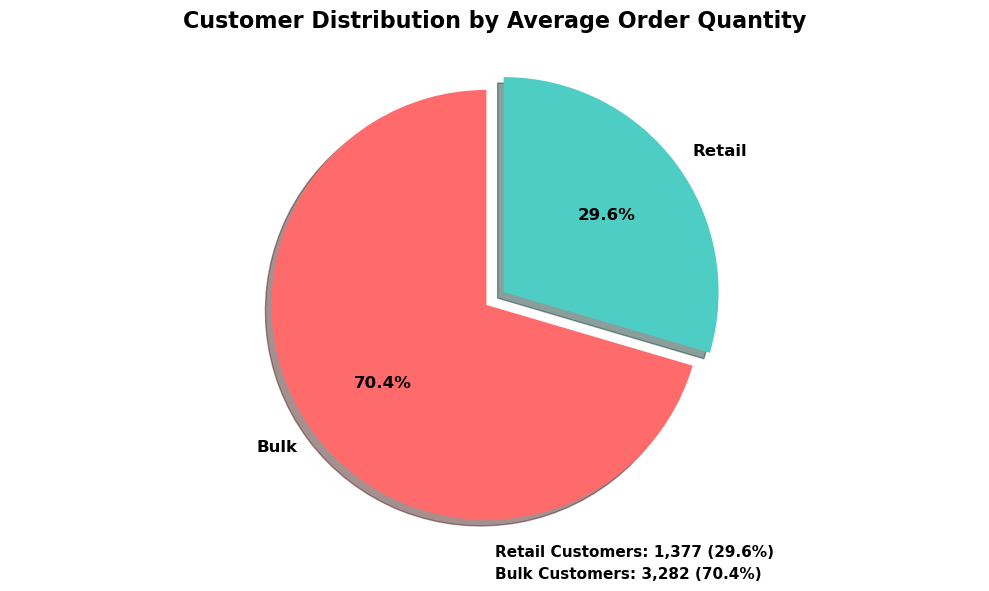

In [ ]:
# Create pie plot of customer segments
customer_segment_counts = sales_clean['CustomerNo'].drop_duplicates().map(
    lambda x: 'Retail' if x in set1 else 'Bulk'
).value_counts()

plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4']  
explode = (0.05, 0.05)  

wedges, texts, autotexts = plt.pie(customer_segment_counts.values, 
                                   labels=customer_segment_counts.index,
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   explode=explode,
                                   shadow=True,
                                   startangle=90,
                                   textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Customer Distribution by Average Order Quantity', 
          fontsize=16, fontweight='bold', pad=20)

# Add count information to the labels
for i, (label, count) in enumerate(zip(customer_segment_counts.index, customer_segment_counts.values)):
    percentage = count / customer_segment_counts.sum() * 100
    plt.text(0, -1.3 + i*0.1, f'{label} Customers: {count:,} ({percentage:.1f}%)', 
             ha='left', fontsize=11, fontweight='bold')

plt.axis('equal')  
plt.tight_layout()
plt.show()

### Key metrics

In [11]:
# Key metrics calculations
total_revenue = sales_clean['revenue'].sum()
total_customers = sales_clean['CustomerNo'].nunique()
total_products = sales_clean['ProductNo'].nunique()
avg_order_value = sales_clean['revenue'].mean()
date_range = f"{sales_clean['Date'].min().strftime('%Y-%m-%d')} to {sales_clean['Date'].max().strftime('%Y-%m-%d')}"

# UK market analysis
uk_revenue = sales_clean[sales_clean['Country'] == 'United Kingdom']['revenue'].sum()
uk_percentage = (uk_revenue / total_revenue) * 100

# Seasonal and temporal insights
seasonal = sales_clean.groupby('month')['revenue'].sum()
dow_revenue = sales_clean.groupby('day_of_week')['revenue'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

peak_month = seasonal.idxmax()
peak_day = dow_revenue.idxmax()

print(f" Total Revenue: £{total_revenue:,.2f}")
print(f" Total Customers: {total_customers:,}")
print(f" Product Catalog: {total_products:,}")
print(f" Average Order Value: £{avg_order_value:.2f}")
print(f" Average Quantity per Transaction: {avg_quantity_per_transaction:.2f}")
print(f" Date Range: {date_range}")
print(f" UK Market Share: {uk_percentage:.1f}%")
print(f" Peak Month: {peak_month}")
print(f" Best Day: {peak_day}")

 Total Revenue: £59,127,353.69
 Total Customers: 4,659
 Product Catalog: 3,746
 Average Order Value: £119.15
 Average Quantity per Transaction: 272.90
 Date Range: 2018-12-01 to 2019-11-30
 UK Market Share: 82.8%
 Peak Month: 11
 Best Day: Sunday


### Top Products by Revenue


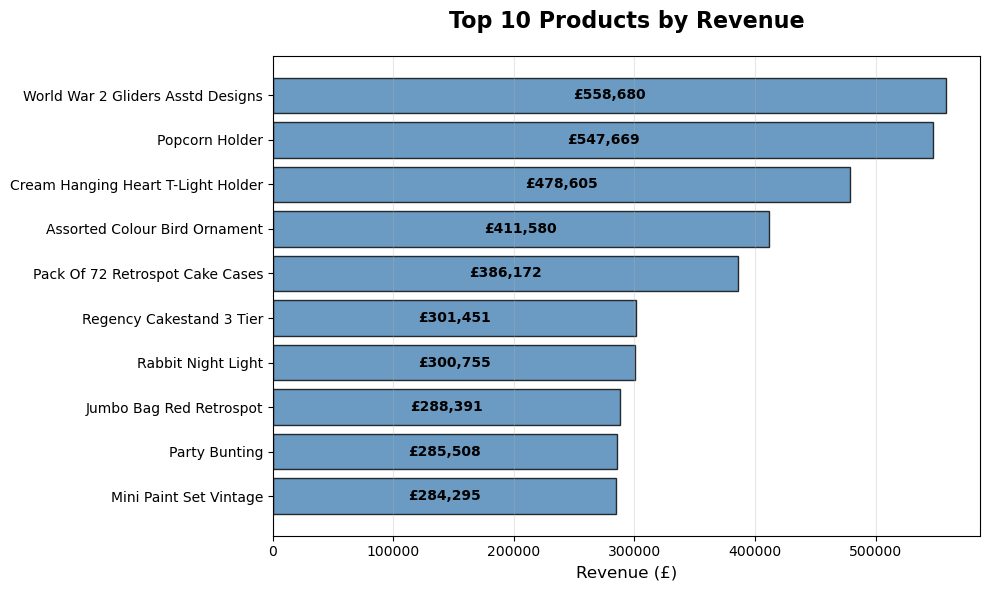

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.barh(range(len(top_products_revenue)), top_products_revenue.values, 
                color='steelblue', alpha=0.8, edgecolor='black')

plt.yticks(range(len(top_products_revenue)), 
           [name[:40] + '...' if len(name) > 40 else name for name in top_products_revenue.index])
plt.xlabel('Revenue (£)', fontsize=12)
plt.title('Top 10 Products by Revenue', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(top_products_revenue.values):
    plt.text(v / 2, i, f'£{v:,.0f}', 
             va='center', ha='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

### Monthly Revenue 

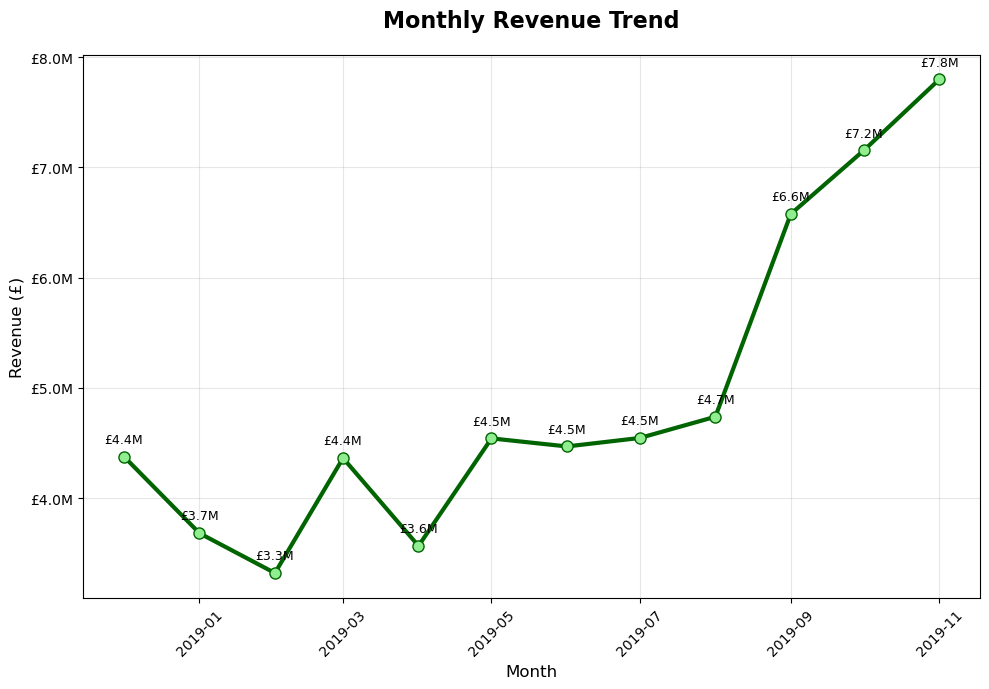

In [13]:
plt.figure(figsize=(10, 7))

plt.plot(monthly_revenue['date'], monthly_revenue['revenue'], 
         marker='o', linewidth=3, markersize=8, color='darkgreen', markerfacecolor='lightgreen')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.title('Monthly Revenue Trend', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

# Add value labels on points
for i, row in monthly_revenue.iterrows():
    plt.annotate(f'£{row["revenue"]/1e6:.1f}M', 
                (row['date'], row['revenue']), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


### Top Countries by Revenue

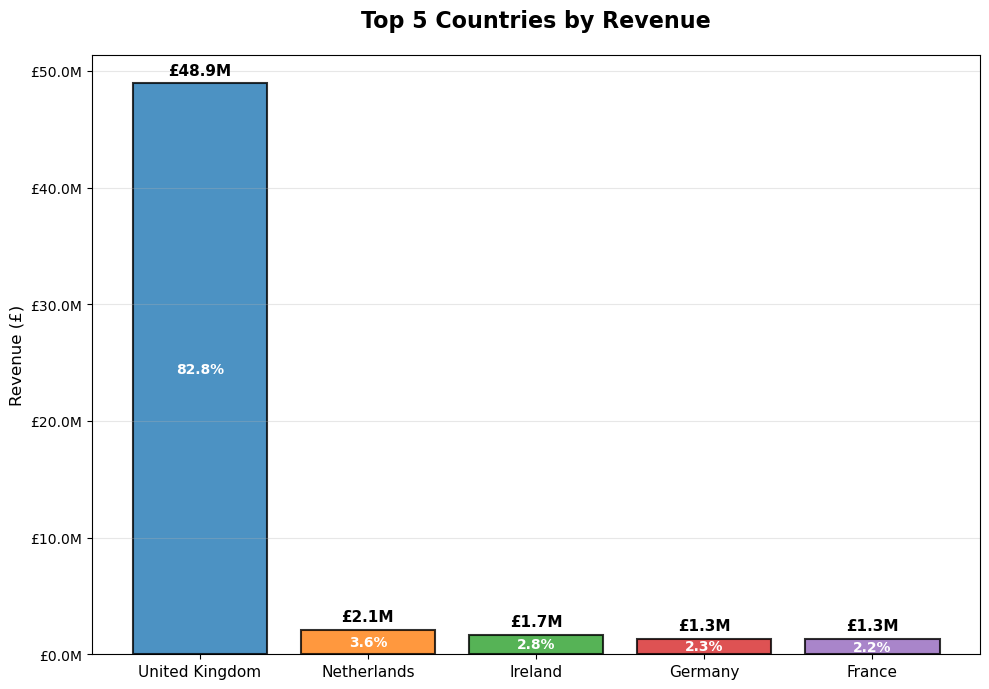

In [14]:
plt.figure(figsize=(10, 7))

bars = plt.bar(range(len(top_countries)), top_countries.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], 
               alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xticks(range(len(top_countries)), top_countries.index, fontsize=11)
plt.ylabel('Revenue (£)', fontsize=12)
plt.title('Top 5 Countries by Revenue', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

# Add value labels on bars
for i, v in enumerate(top_countries.values):
    plt.text(i, v + max(top_countries.values) * 0.01, f'£{v/1e6:.1f}M', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add percentage labels
total_revenue = top_countries.sum()
for i, v in enumerate(top_countries.values):
    pct = (v / sales_clean['revenue'].sum()) * 100
    plt.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()


### Top categories

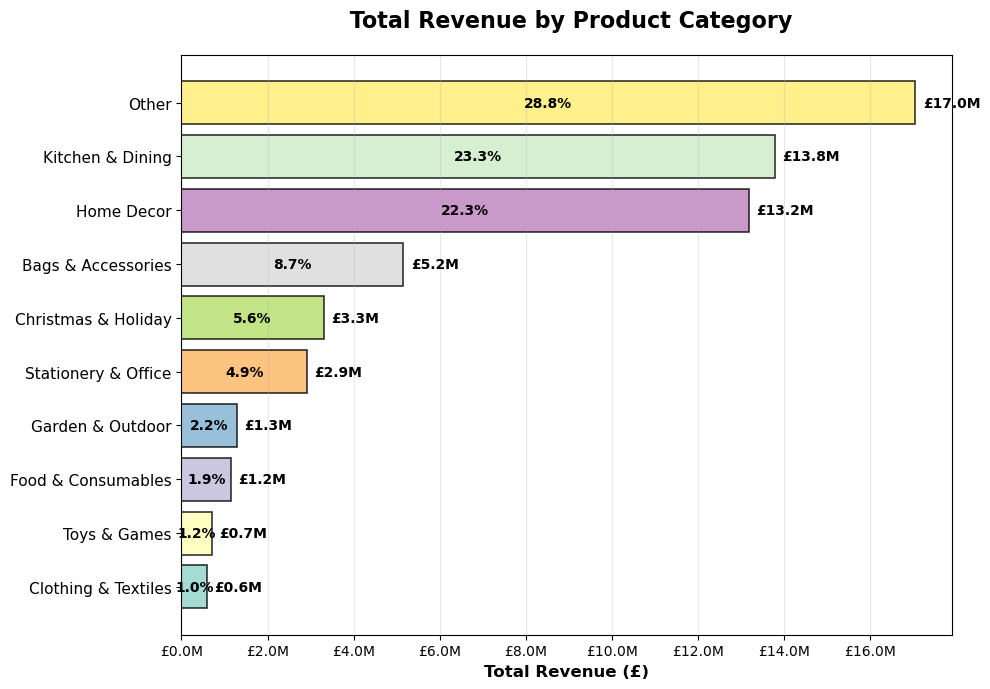

In [15]:
category_metrics = sales_clean.groupby('Category').agg({
    'revenue': ['sum', 'mean', 'count'],
    'Quantity': 'sum',
    'CustomerNo': 'nunique',
    'ProductNo': 'nunique'
}).round(2)

category_metrics.columns = ['total_revenue', 'avg_revenue', 'transaction_count', 
                           'total_quantity', 'unique_customers', 'unique_products']
category_metrics['revenue_percentage'] = (category_metrics['total_revenue'] / 
                                        category_metrics['total_revenue'].sum() * 100).round(1)
category_metrics = category_metrics.sort_values('total_revenue', ascending=False)

# Category Revenue Distribution
plt.figure(figsize=(10, 7))
revenue_data = category_metrics.sort_values('total_revenue', ascending=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(revenue_data)))

bars = plt.barh(range(len(revenue_data)), revenue_data['total_revenue'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

plt.yticks(range(len(revenue_data)), revenue_data.index, fontsize=11)
plt.xlabel('Total Revenue (£)', fontsize=12, fontweight='bold')
plt.title(' Total Revenue by Product Category', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

for i, v in enumerate(revenue_data['total_revenue']):
    plt.text(v + max(revenue_data['total_revenue']) * 0.01, i, f'£{v/1e6:.1f}M', 
             va='center', fontsize=10, fontweight='bold')

for i, (idx, row) in enumerate(revenue_data.iterrows()):
    pct = row['revenue_percentage']
    plt.text(row['total_revenue']/2, i, f'{pct}%', 
             ha='center', va='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


##  6. RFM Analysis (Customer Segmentation)


In [16]:
# RFM Analysis
current_date = sales_clean['Date'].max()

rfm = sales_clean.groupby('CustomerNo').agg({
    'Date': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionNo': 'count',                          # Frequency  
    'revenue': 'sum'                                   # Monetary
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create RFM scores (1-5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerNo,,,,,,
12004,218,56,1509.60,1,3,2
12006,209,1,24.76,1,1,1
12008,267,203,5689.57,1,5,3
12013,350,1,69.96,1,1,1
12024,167,5,149.52,2,1,1


In [17]:
# Customer segmentation based on RFM scores
def segment_customers(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'VIP'
    elif r >= 3 and f >= 4:
        return 'Loyal Customers'
    elif r >= 4 and f >= 2 and m >= 2:
        return 'Potential Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f >= 3 and m >= 4:
        return "Top at Risk"
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Hibernating'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Need Activation'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)


print("Customer Segment Distribution:")
print(rfm['Segment'].value_counts())


Customer Segment Distribution:
VIP                          936
Need Activation              893
Others                       789
At Risk                      577
Potential Loyal Customers    521
Loyal Customers              514
New Customers                241
Hibernating                  188
Name: Segment, dtype: int64


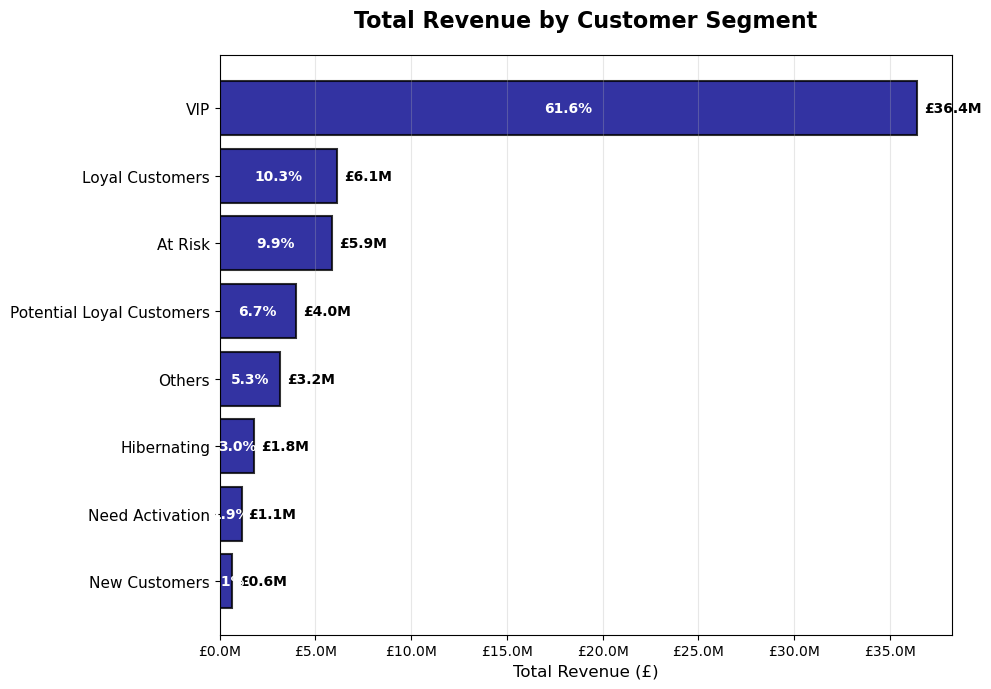

In [18]:
# RFM Visualization: Revenue by Customer Segment
plt.figure(figsize=(10, 7))
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=True)

bars = plt.barh(range(len(segment_revenue)), segment_revenue.values, 
                color='darkblue', alpha=0.8, edgecolor='black', linewidth=1.5)

plt.yticks(range(len(segment_revenue)), segment_revenue.index, fontsize=11)
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.title('Total Revenue by Customer Segment', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

for i, v in enumerate(segment_revenue.values):
    plt.text(v + max(segment_revenue.values) * 0.01, i, f'£{v/1e6:.1f}M', 
             va='center', fontsize=10, fontweight='bold')

total_rfm_revenue = segment_revenue.sum()
for i, v in enumerate(segment_revenue.values):
    pct = (v / total_rfm_revenue) * 100
    plt.text(v/2, i, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()


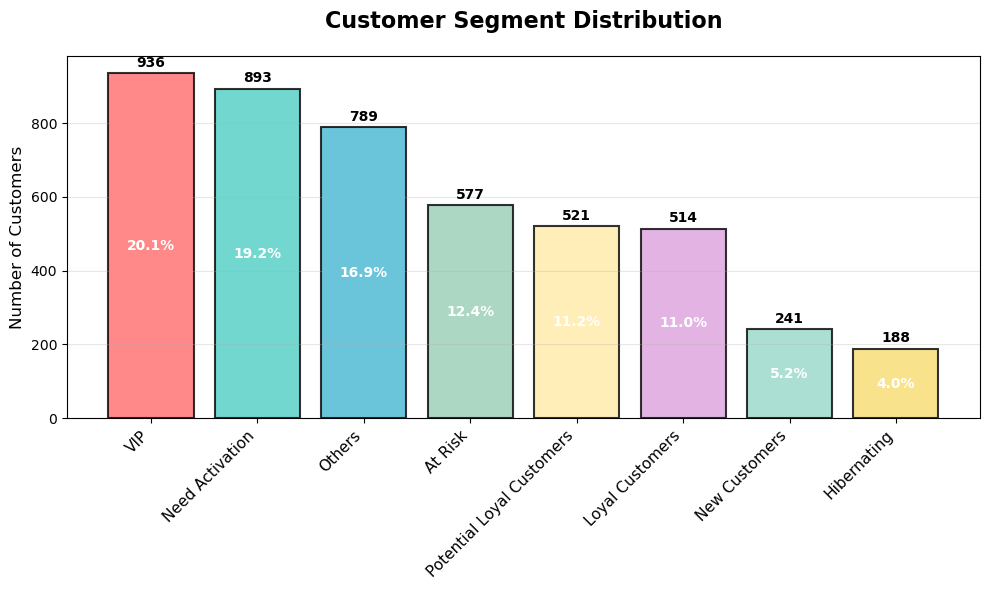

In [19]:
# Customer Segment Distribution
plt.figure(figsize=(10, 6))
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)

# Create a beautiful color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

# Create bar chart
bars = plt.bar(range(len(segment_counts)), segment_counts.values, 
               color=colors[:len(segment_counts)], alpha=0.8, edgecolor='black', linewidth=1.5)

plt.xticks(range(len(segment_counts)), segment_counts.index, fontsize=11, rotation=45, ha='right')
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(segment_counts.values):
    plt.text(i, v + max(segment_counts.values) * 0.01, f'{v:,}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add percentage labels inside bars
total_customers = segment_counts.sum()
for i, v in enumerate(segment_counts.values):
    pct = (v / total_customers) * 100
    plt.text(i, v/2, f'{pct:.1f}%', ha='center', va='center', 
             fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

### Pareto Priciple

In [20]:
#Pareto Analysis 
pareto_df = rfm[['Monetary']].sort_values(by='Monetary', ascending=False).copy()
pareto_df['Cumulative_Revenue'] = pareto_df['Monetary'].cumsum()
pareto_df['Cumulative_Percent_Revenue'] = 100 * pareto_df['Cumulative_Revenue'] / pareto_df['Monetary'].sum()
pareto_df['Cumulative_Percent_Customers'] = 100 * (pareto_df.reset_index().index + 1) / len(pareto_df)

#Identify 80% revenue contributors
top_20_cutoff = pareto_df[pareto_df['Cumulative_Percent_Revenue'] <= 80]
num_top_customers = len(top_20_cutoff)
percentage_top_customers = 100 * num_top_customers / len(pareto_df)

print(f"{percentage_top_customers:.1f}% of customers generate 80% of total revenue.")

28.3% of customers generate 80% of total revenue.


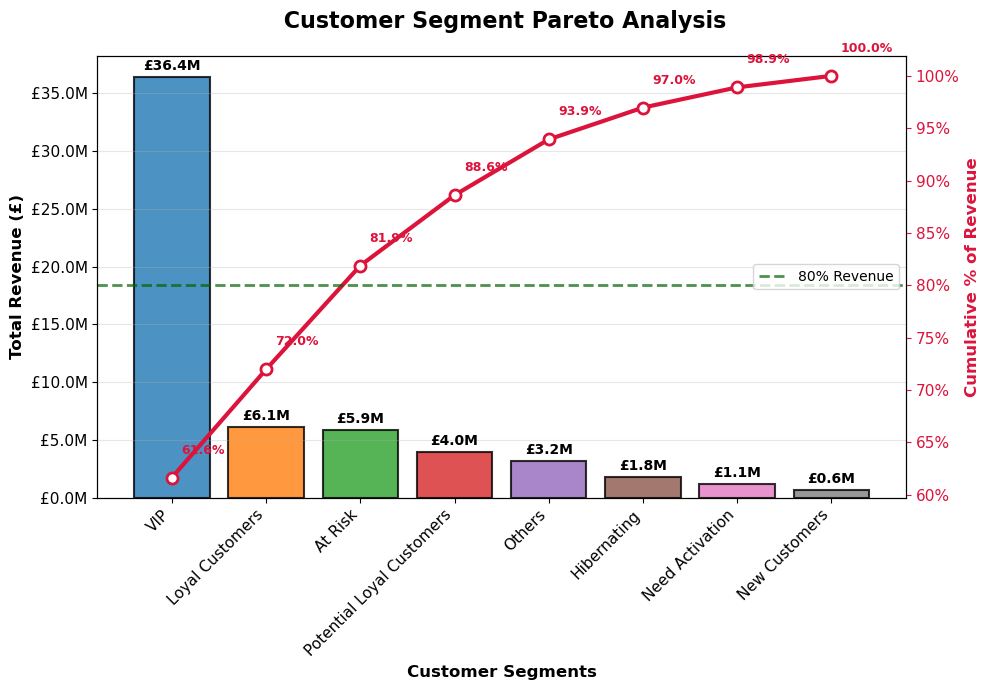

PARETO ANALYSIS INSIGHTS
Top 3 segments generate: £48.4M (81.9% of total revenue)
80% revenue threshold reached at: At Risk segment


In [21]:
# Customer Segment Pareto Analysis 
plt.figure(figsize=(10, 7))

# Prepare data
segments_pareto = (
    rfm.groupby('Segment')['Monetary']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'Segment': 'Segment_labels', 'Monetary': 'TotalMonetary'})
)

# Compute cumulative percentage of revenue
segments_pareto['CumulativeMonetary'] = segments_pareto['TotalMonetary'].cumsum()
segments_pareto['CumulativePercentage'] = 100 * segments_pareto['CumulativeMonetary'] / segments_pareto['TotalMonetary'].sum()

# Create the main axis for bars
ax1 = plt.gca()

# Create bars with consistent styling
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
bars = ax1.bar(range(len(segments_pareto)), segments_pareto['TotalMonetary'], 
               color=colors[:len(segments_pareto)], alpha=0.8, edgecolor='black', linewidth=1.5)

# Create secondary axis for cumulative percentage line
ax2 = ax1.twinx()
line = ax2.plot(range(len(segments_pareto)), segments_pareto['CumulativePercentage'],
                color='crimson', marker='o', markersize=8, linewidth=3, 
                markerfacecolor='white', markeredgecolor='crimson', markeredgewidth=2)

# Add 80% reference line
ax2.axhline(80, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7, label='80% Revenue')

# Styling consistent with other plots
ax1.set_xlabel('Customer Segments', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Revenue (£)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative % of Revenue', fontsize=12, fontweight='bold', color='crimson')

# Format axes
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

# Set x-ticks
ax1.set_xticks(range(len(segments_pareto)))
ax1.set_xticklabels(segments_pareto['Segment_labels'], fontsize=11, rotation=45, ha='right')

# Title and grid
plt.title(' Customer Segment Pareto Analysis', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(segments_pareto['TotalMonetary']):
    ax1.text(i, v + max(segments_pareto['TotalMonetary']) * 0.01, f'£{v/1e6:.1f}M', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add cumulative percentage labels on line
for i, (revenue, cum_pct, segment) in enumerate(zip(segments_pareto['TotalMonetary'], 
                                                    segments_pareto['CumulativePercentage'],
                                                    segments_pareto['Segment_labels'])):
    # Cumulative percentage on line
    ax2.text(i + 0.1, cum_pct + 2, f'{cum_pct:.1f}%', ha='left', va='bottom', 
             fontsize=9, fontweight='bold', color='crimson')

# Add legend for the reference line
ax2.legend(loc='center right', fontsize=10)

# Color the y-axis labels to match their data
ax2.tick_params(axis='y', colors='crimson', labelsize=11)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)

plt.tight_layout()
plt.show()

# Print insights
print("PARETO ANALYSIS INSIGHTS")
top_3_segments = segments_pareto.head(3)
top_3_revenue = top_3_segments['TotalMonetary'].sum()
total_revenue = segments_pareto['TotalMonetary'].sum()
top_3_percentage = (top_3_revenue / total_revenue) * 100

print(f"Top 3 segments generate: £{top_3_revenue/1e6:.1f}M ({top_3_percentage:.1f}% of total revenue)")
print(f"80% revenue threshold reached at: {segments_pareto[segments_pareto['CumulativePercentage'] >= 80].iloc[0]['Segment_labels']} segment")


##  7. Cohort Analysis (Customer Retention)


In [22]:
# Prepare data for cohort analysis
cohort = sales_clean[['CustomerNo','Date','ProductName']].copy()

print("Date Range for Cohort Analysis:")
print(f"From: {cohort['Date'].min()}")
print(f"To: {cohort['Date'].max()}")

# Create period columns
cohort['order_month'] = cohort['Date'].dt.to_period('M')

# Create cohort data
df_cohort = cohort.copy()
df_cohort['cohort'] = df_cohort.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')
df_cohort = df_cohort.groupby(['cohort','order_month']).agg(n_customers=('CustomerNo','nunique')).reset_index()
df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(attrgetter('n'))

df_cohort.head()


Date Range for Cohort Analysis:
From: 2018-12-01 00:00:00
To: 2019-11-30 00:00:00


,cohort,order_month,n_customers,period_number
0,2018-12,2018-12,1025,0
1,2018-12,2019-01,340,1
2,2018-12,2019-02,309,2
3,2018-12,2019-03,368,3
4,2018-12,2019-04,353,4


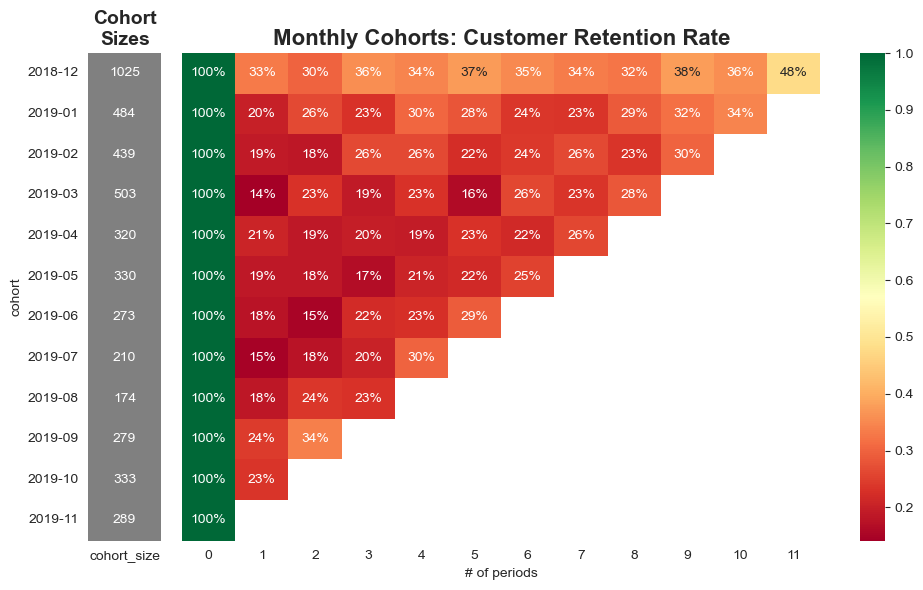

In [23]:
# Create cohort pivot table and retention matrix
cohort_pivot = df_cohort.pivot_table(index='cohort', 
                                     columns='period_number', 
                                     values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Cohort Analysis Visualization
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Retention matrix heatmap
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: Customer Retention Rate', fontsize=16, fontweight='bold')
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # Cohort size heatmap
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['grey'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    ax[0].set_title('Cohort\nSizes', fontsize=14, fontweight='bold')

    fig.tight_layout()
    plt.show()


In [29]:
print("Retention Pattern Analysis")

# Calculate specific first-month retention rates
first_month_rates = retention_matrix.iloc[:, 1].dropna()
avg_first_month = first_month_rates.mean()

print("\nFirst Month Dropoff:")
print(f"   • Average first-month retention: {avg_first_month:.1%}")
print(f"   • Customer loss in first month: {1-avg_first_month:.1%}")

print("\nAnalysis (Excluding December 2018 becuase its the first month of the analysis):")
seasonal_analysis = []
for cohort, rate in retention_matrix.iloc[:, 1].dropna().items():
    if hasattr(cohort, 'month'):
        month = cohort.month
        if not (cohort.year == 2018 and month == 12):
            seasonal_analysis.append((month, rate, str(cohort)))

seasonal_df = pd.DataFrame(seasonal_analysis, columns=['Month', 'Retention', 'Cohort'])
seasonal_avg = seasonal_df.groupby('Month')['Retention'].mean().sort_values(ascending=False)
    
print("   Top 3 months for retention :")
for i, (month, rate) in enumerate(seasonal_avg.head(3).items()):
        print(f"   {i+1}. Month {month}: {rate:.1%}")
    
print("\n   Bottom 3 months for retention :")
for i, (month, rate) in enumerate(seasonal_avg.tail(3).items()):
    print(f"   {i+1}. Month {month}: {rate:.1%}")
    
   


Retention Pattern Analysis

First Month Dropoff:
   • Average first-month retention: 20.4%
   • Customer loss in first month: 79.6%

Analysis (Excluding December 2018 becuase its the first month of the analysis):
   Top 3 months for retention :
   1. Month 9: 24.4%
   2. Month 10: 23.4%
   3. Month 4: 20.6%

   Bottom 3 months for retention :
   1. Month 6: 17.6%
   2. Month 7: 14.8%
   3. Month 3: 14.1%


## 8. Market Basket Analysis

In [25]:

#market basket analysis df
mba_df = sales_clean.copy()
cust_prod  = mba_df.groupby(['CustomerNo', 'Date'])['ProductName'].apply(list)
cust_prod_list = cust_prod.to_list()
#inputs
supp = 1
conf = 5
report = 'SacClL' # SacClL 
report_colnames = {
    'a': 'support_itemset_absolute',
    's': 'support_itemset_relative',
    'S': 'support_itemset_relative_pct',
    'b': 'support_bodyset_absolute',
    'x': 'support_bodyset_relative',
    'X': 'support_bodyset_relative_pct',
    'h': 'support_headitem_absolute',
    'y': 'support_headitem_relative',
    'Y': 'support_headitem_relative_pct',
    'c': 'confidence',
    'C': 'confidence_pct',
    'l': 'lift',
    'L': 'lift_pct',
    'e': 'evaluation',
    'E': 'evaluation_pct',
    'Q': 'support of the empty set (total number of transactions)'
    }
#apriori
apriori = arules(cust_prod_list,supp=supp,conf=conf,report=report,zmin= 2,zmax = 2, eval = 'x')
#Creat dataframe with columns based on the report variables and sorted based on the "Associations_Sorted_based_on"
colnames = ['Cons_Product', 'antecedent'] + [report_colnames.get(k, k) for k in list(report)]
df_rules = pd.DataFrame(apriori, columns=colnames)
df_rules = df_rules.sort_values(report_colnames["a"], ascending=False)
df_rules = df_rules[['antecedent', 'Cons_Product']+ [report_colnames.get(k, k) for k in list(report)]]

df_rules.head(5)

,antecedent,Cons_Product,support_itemset_relative_pct,support_itemset_absolute,confidence,confidence_pct,lift,lift_pct
1057,"(Jumbo Bag Red Retrospot,)",Jumbo Bag Pink Polkadot,4.663423,805,0.400298,40.029836,5.811565,581.156457
1056,"(Jumbo Bag Pink Polkadot,)",Jumbo Bag Red Retrospot,4.663423,805,0.677040,67.703953,5.811565,581.156457
406,"(Roses Regency Teacup And Saucer,)",Green Regency Teacup And Saucer,4.263701,736,0.718750,71.875000,12.699143,1269.914278
407,"(Green Regency Teacup And Saucer,)",Roses Regency Teacup And Saucer,4.263701,736,0.753327,75.332651,12.699143,1269.914278
183,"(Jumbo Bag Red Retrospot,)",Jumbo Storage Bag Suki,4.049357,699,0.347588,34.758826,5.249404,524.940387


In [26]:
#Total Transactions
print(f"Total Transactions: {sales_clean['TransactionNo'].nunique()}")
#Average Items per Transaction
print(f"Average Items per Transaction: {sales_clean.groupby('TransactionNo')['ProductName'].count().sum()/sales_clean['TransactionNo'].nunique():.1f}")
#Max Items in Transaction
print(f"Max Items in Transaction: {sales_clean.groupby('TransactionNo')['ProductName'].count().max()}")
#Transactions with multiple items
print(f'''Transactions with multiple items: {(sales_clean.groupby('TransactionNo')['ProductName'].nunique() > 1).sum()
      } | {((sales_clean.groupby('TransactionNo')['ProductName'].nunique() > 1).sum()/sales_clean['TransactionNo'].nunique())*100:.1f}% of total transactions''')
print("\nTOP 10 PRODUCT ASSOCIATIONS (by Lift and Confidence):\n")
for i, row in df_rules.sort_values(by=['confidence','lift'], ascending=False).head(10).iterrows():
    print(f"{row['antecedent']} → {row['Cons_Product']} | Lift: {row['lift']:.2f} | Conf: {row['confidence']:.1%}")
print("\nTOP 10 PRODUCT ASSOCIATIONS (by Support):\n")
for i, row in df_rules.sort_values(by='support_itemset_absolute', ascending=False).head(10).iterrows():
    print(f"{row['antecedent']} → {row['Cons_Product']} | Support: {row['support_itemset_relative_pct']:.2f}% | Count: {row['support_itemset_absolute']:,}")

Total Transactions: 18920
Average Items per Transaction: 26.2
Max Items in Transaction: 1110
Transactions with multiple items: 17487 | 92.4% of total transactions

TOP 10 PRODUCT ASSOCIATIONS (by Lift and Confidence):

('Herb Marker Thyme',) → Herb Marker Rosemary | Lift: 71.00 | Conf: 93.4%
('Herb Marker Rosemary',) → Herb Marker Thyme | Lift: 71.00 | Conf: 93.0%
('Herb Marker Chives',) → Herb Marker Parsley | Lift: 70.88 | Conf: 92.4%
('Herb Marker Chives',) → Herb Marker Thyme | Lift: 69.79 | Conf: 91.4%
('Regency Tea Plate Pink',) → Regency Tea Plate Green | Lift: 43.73 | Conf: 91.2%
('Herb Marker Chives',) → Herb Marker Mint | Lift: 69.10 | Conf: 90.9%
('Herb Marker Chives',) → Herb Marker Rosemary | Lift: 69.10 | Conf: 90.9%
('Herb Marker Parsley',) → Herb Marker Thyme | Lift: 69.25 | Conf: 90.7%
('Herb Marker Parsley',) → Herb Marker Rosemary | Lift: 68.95 | Conf: 90.7%
('Herb Marker Thyme',) → Herb Marker Parsley | Lift: 69.25 | Conf: 90.3%

TOP 10 PRODUCT ASSOCIATIONS (by Supp